In [1]:
import numpy as np
from networkx import karate_club_graph, to_numpy_matrix, adjacency_matrix
from sklearn.datasets.samples_generator import make_circles
from sklearn.cluster import SpectralClustering, KMeans
from sklearn.metrics import pairwise_distances
from sklearn import metrics

zkc = karate_club_graph()

A = adjacency_matrix(zkc)

X = np.diag(np.ones(34))
#ground_truth = np.array([0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,1,0,1,1,1,1,1,1,1,1,1,1,1,1])
ground_truth = np.array([1,1,2,1,0,0,0,1,3,2,0,1,1,1,3,3,0,1,3,1,3,1,3,3,2,2,3,2,2,3,3,2,3,3])
y = []
def return_y(element):
    if element==0:
        y.append([1,0,0,0])
    elif element==1:
         y.append([0,1,0,0])
    elif element==2:
         y.append([0,0,1,0])
    elif element ==3:
         y.append([0,0,0,1])       
for element in ground_truth:
    return_y(element)

#y =  np.array([[1,0] if i == 0 else [0,1] for i in ground_truth])
y = np.array(y)

common_masks = np.zeros(34)
common_masks[0] = 1
common_masks[33] = 1
common_masks[16] = 1
common_masks[24] = 1
train_mask =  val_mask = common_masks

common_masks = np.ones(34)
test_mask = common_masks


In [2]:
N = A.shape[0] # N = 2708
F = X.shape[-1] #X.shape = 2708*1433  = 2708 nodes, 1433 features, F = 1433
n_classes = y.shape[-1] # n_classes = 7

Check type of initiated array.

In [3]:
print(type(y))
print(type(train_mask))
print(type(val_mask))
print(type(test_mask))
print(N)
print(F)
print(n_classes)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
34
34
4


Building the model is no different than building any Keras model, 
but we will need to provide multiple inputs to the GraphConv layers (namely A and X):

In [4]:
from spektral.layers import GraphConv
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dropout

In [5]:

# Model definition
X_in = Input(shape=(F, ))  # This imply expected input will be batches of F-dimensional matrix (F=1433, input features)
A_in = Input((N, ), sparse=True)  # IThis imply expected input will be batches of N-dimensional matrix (N=2704, input adjacency), it is a sparse matrix.

graph_conv_1 = GraphConv(8, activation='relu')([X_in, A_in])
#dropout = Dropout(0.5)(graph_conv_1)
graph_conv_2 = GraphConv(n_classes, activation='softmax')([graph_conv_1, A_in])

# Build model
model = Model(inputs=[X_in, A_in], outputs=graph_conv_2)

An important thing to notice at this point is how we defined the Input layers of our model. 

Because the "elements" of our dataset are the node themselves, we are telling Keras to consider each node as a separate sample, 
so that the "batch" axis is implicitly defined as None.
In other words, a sample of the node attributes will be _a row vector of shape (F, )_ and a sample of the adjacency matrix will be _one of its rows of shape (N, )_. (因為只需要睇該node的所有adjecency node)

Keep this detail in mind for later.

Before training the model, we have to pre-process the adjacency matrix to scale the weights of a node's connections according to its degree. 

In other words, the more a node is connected to others, the less relative importance those connections have. Most GNN layers available in Spektral require their own type of pre-processing in order to work correctly. You can find all necessary tools for pre-processing A in _spektral.utils_.

In [6]:
from spektral import utils
A = utils.localpooling_filter(A).astype('f4') 

In [7]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              weighted_metrics=['acc'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 34)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
graph_conv (GraphConv)          (None, 8)            280         input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
graph_conv_1 (GraphConv)        (None, 4)            36          graph_conv[0][0]             

In [10]:
print(N, ' ', F, ' ', n_classes)
print(type(y))
print(type(train_mask))

34   34   4
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [111]:
from tensorflow.keras.callbacks import EarlyStopping
# Prepare data
validation_data = ([X, A], y, val_mask)

# Train model
model.fit([X, A],
          y,
          sample_weight=train_mask,
          epochs=300,
          batch_size=N, #batch size = no of nodes. Put all nodes into neural network at once.
          validation_data=validation_data,
          shuffle=False,  # Shuffling data means shuffling the whole graph
          callbacks=[
              EarlyStopping(patience=10,  restore_best_weights=True)
          ])


Epoch 155/300
34/34 [==============================] - 0s 588us/sample - loss: 0.1238 - acc: 0.7500 - val_loss: 0.1235 - val_acc: 0.7500
Epoch 156/300
34/34 [==============================] - 0s 735us/sample - loss: 0.1235 - acc: 0.7500 - val_loss: 0.1233 - val_acc: 0.7500
Epoch 157/300
34/34 [==============================] - 0s 529us/sample - loss: 0.1233 - acc: 0.7500 - val_loss: 0.1230 - val_acc: 0.7500
Epoch 158/300
34/34 [==============================] - 0s 676us/sample - loss: 0.1230 - acc: 0.7500 - val_loss: 0.1228 - val_acc: 0.7500
Epoch 159/300
34/34 [==============================] - 0s 617us/sample - loss: 0.1228 - acc: 0.7500 - val_loss: 0.1225 - val_acc: 0.7500
Epoch 160/300
34/34 [==============================] - 0s 647us/sample - loss: 0.1225 - acc: 0.7500 - val_loss: 0.1222 - val_acc: 0.7500
Epoch 161/300
34/34 [==============================] - 0s 588us/sample - loss: 0.1222 - acc: 0.7500 - val_loss: 0.1220 - val_acc: 0.7500
Epoch 162/300
34/34 [====================

In [112]:
# Evaluate model
eval_results = model.evaluate([X, A],
                              y,
                              sample_weight=test_mask,
                              batch_size=N)
print('Done.\n'
      'Test loss: {}\n'
      'Test accuracy: {}'.format(*eval_results))

  ...
    to  
  ['...']
34/34 [==============================] - 0s 88us/sample - loss: 1.0274 - acc: 0.8824
Done.
Test loss: 1.0273925065994263
Test accuracy: 0.8823529481887817


In [113]:

y_result = model.predict([X,A], batch_size=N)
y_group = []
for index, item in enumerate(y_result):
    y_group.append(np.argmax(y_result[index]))

34.0


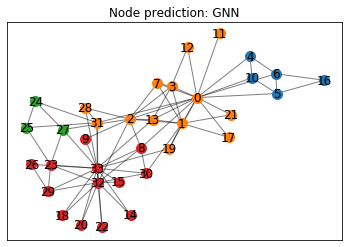

In [114]:
import networkx as nx
import matplotlib.pyplot as plt
def get_node_color(input):
    if input==1:
        return "red"
    elif input==2:
        return "green"
    elif input==3:
        return "blue"
    elif input ==4:
        return "yellow"

#drawing
size = float(len(ground_truth))
print(size)
labels_dict = dict(enumerate(y_group, 0))
pos = nx.spring_layout(zkc)
count = 0.
for com in set(y_group) :
    count = count + 1.
    list_nodes = [nodes for nodes in labels_dict
                                if labels_dict[nodes] == com]
    nx.draw_networkx_nodes(zkc, pos, list_nodes, node_size = 100,
                                node_color = get_node_color(count / size))


nx.draw_networkx_edges(zkc, pos, alpha=0.5)
nx.draw_networkx_labels(zkc, pos)
plt.title('Node prediction: GNN')
plt.show()

In [115]:
from sklearn import metrics
print(metrics.adjusted_rand_score(ground_truth, y_group))
print(metrics.adjusted_mutual_info_score(ground_truth, y_group))
print(metrics.accuracy_score(ground_truth, y_group))
print(ground_truth)
print(y_group)

0.7471674243921723
0.7696617221967971
0.8823529411764706
[1 1 2 1 0 0 0 1 3 2 0 1 1 1 3 3 0 1 3 1 3 1 3 3 2 2 3 2 2 3 3 2 3 3]
[1, 1, 1, 1, 0, 0, 0, 1, 3, 3, 0, 1, 1, 1, 3, 3, 0, 1, 3, 1, 3, 1, 3, 3, 2, 2, 3, 2, 1, 3, 3, 1, 3, 3]


In [116]:
np.argmax(y_result, axis=-1)

array([1, 1, 1, 1, 0, 0, 0, 1, 3, 3, 0, 1, 1, 1, 3, 3, 0, 1, 3, 1, 3, 1,
       3, 3, 2, 2, 3, 2, 1, 3, 3, 1, 3, 3], dtype=int64)